In [1]:
import os
import sys
import json
from scipy import stats
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from tqdm import tqdm
import warnings
import matplotlib as mpl
import plot_utils

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
ot1_color = 'tab:green'
palette_tcrs = {'OT1': ot1_color, 
                'OTI': ot1_color, 
                'OT-I': ot1_color, 
                'Educated': 'tab:orange',
                'Naive': 'tab:blue',
                'Naïve': 'tab:blue',
                'Human': 'Firebrick'
               }

color_random ='silver'
color_mice = 'silver'

palette_human = 'Reds'

color_mice = 'silver'
color_cdr3 = 'violet'
cmap_distances = 'viridis_r'

## Load Data

In [6]:
def compute_classification_metrics(g):
    return pd.Series({
        'AUC': (
            metrics.roc_auc_score(g['is_activated'], g['pred'])
            if np.isfinite(g['pred']).all() and 0 < g['is_activated'].mean() < 1
            else np.nan
        ),
        'APS': (
            metrics.average_precision_score(g['is_activated'], g['pred'])
            if np.isfinite(g['pred']).all()
            else np.nan
        ),
    })

In [7]:
def compute_regression_metrics(g):
    return pd.Series({
        'MAE': g['abserr'].mean(),
        'R2': metrics.r2_score(g['activation'], g['pred']),
        'Pearson': g['activation'].corr(g['pred'], method='pearson'),
        'Spearman': g['activation'].corr(g['pred'], method='spearman'),
    })

In [8]:
def load_classification_data():
    fname = f'../activation-prediction/results'
    pdf = pd.read_csv(f'{fname}/VPSVWRSSL_tcr_stratified_classification_performance.csv.gz')
    
    pdf = pdf[pdf['normalization']=='pc']
    pdf = pdf[pdf['threshold']==66.09]
    pdf = pdf[pdf['reduced_features']]
    
    pdf = pdf.query('mut_pos >= 0')
    pdf = pdf.groupby([
        'normalization', 'tcr'
    ]).filter(lambda g: 0 < g['is_activated'].sum() < len(g) - 1)

    pdf['Repertoire'] = 'Human'

    df_metrics = pdf.groupby(['tcr'], as_index=False).apply(compute_classification_metrics).reset_index()

    df_metrics['Repertoire'] = 'Human'
    return pdf, df_metrics
pdf_classification, df_classification_metrics = load_classification_data()

In [9]:
def load_regression_data():
    fname = f'../activation-prediction/results'
    pdf = pd.read_csv(f'{fname}/VPSVWRSSL_tcr_stratified_regression_performance.csv.gz')
    
    pdf = pdf[pdf['normalization']=='pc']
    pdf = pdf.query('mut_pos >= 0')
    pdf['Repertoire'] = 'Human'
    pdf['abserr'] = pdf['err'].abs()
    df_metrics = pdf.groupby(['tcr'], as_index=False).apply(compute_regression_metrics).reset_index()

    df_metrics['Repertoire'] = 'Human'
    return pdf, df_metrics
pdf_regression, df_regression_metrics = load_regression_data()

### Baseline Data

In [10]:
def load_ergo_data(db, suffix='', full=True):
    if full:
        df_normal = load_ergo_data(db, '', full=False)
        df_tumor = load_ergo_data(db, '_tumor', full=False)
        return pd.concat([df_normal, df_tumor])
    path_res = f'../baseline/results_pred/ergo_{db}{suffix}.csv'
    prediction_ergo = pd.read_csv(path_res, index_col=0)
    prediction_ergo = prediction_ergo[prediction_ergo['Peptide'] != 'SIINFEKL']
    prediction_ergo = prediction_ergo[prediction_ergo['tcr'].str.startswith('R')]
    return prediction_ergo

In [11]:
def load_imrex_data(suffix='', full=True):
    if full:
        df_normal = load_imrex_data('', full=False)
        df_tumor = load_imrex_data('_tumor', full=False)
        return pd.concat([df_normal, df_tumor])
    path_imrex = f'../baseline/results_pred/imrex{suffix}.csv'
    prediction_imrex = pd.read_csv(path_imrex, index_col=0)
    prediction_imrex = prediction_imrex[prediction_imrex['antigen.epitope'] != 'SIINFEKL']
    prediction_imrex = prediction_imrex[prediction_imrex['tcr'].str.startswith('R')]
    return prediction_imrex

In [12]:
def get_auc_per_tcr(data, tcr, y_true, col_pred):
    data_tmp = data[data['tcr'] == tcr]
    y_pred = data_tmp[col_pred]
    auc_score = metrics.roc_auc_score(y_true['is_activated'], y_pred)
    return auc_score

def get_spearman_per_tcr(data, tcr, y_true, col_pred):
    data_tmp = data[data['tcr'] == tcr].copy()
    data_tmp['activation_true'] = y_true['activation'].values
    auc_score = data_tmp['activation_true'].corr(data_tmp[col_pred], method='spearman')
    return auc_score

def load_baseline_data(metric='AUC'):
    prediction_ergo_vdjdb = load_ergo_data('vdjdb')
    prediction_ergo_mcpas = load_ergo_data('mcpas')
    prediction_imrex = load_imrex_data()

    for df in [prediction_ergo_vdjdb, prediction_ergo_mcpas, prediction_imrex]:
        df.replace({'ED16_1': 'ED16-1', 'ED16_30': 'ED16-30', 'OTI_PH': 'OTI'}, inplace=True)
    
    prediction_ours = pdf_classification[pdf_classification['tcr'].isin(prediction_ergo_vdjdb['tcr'].unique())]
    
    metric_func = get_auc_per_tcr
    if metric == 'Spearman':
        metric_func = get_spearman_per_tcr
        predictin_outs = pdf_regression[pdf_regression['tcr'].isin(prediction_ergo_vdjdb['tcr'].unique())]
        
    performance = []
    for tcr in prediction_ergo_vdjdb['tcr'].unique():
        if tcr in ['LR_OTI_1', 'LR_OTI_2']:
            continue
        y_true = prediction_ours[prediction_ours['tcr'] == tcr]#['is_activated']
        
        scores_ergo_mcpas = metric_func(prediction_ergo_mcpas, tcr, y_true, col_pred='Score')
        scores_ergo_vdjdb = metric_func(prediction_ergo_vdjdb, tcr, y_true, col_pred='Score')
        scores_imrex = metric_func(prediction_imrex, tcr, y_true, col_pred='prediction_score')
        scores_ours = metric_func(prediction_ours, tcr, y_true, col_pred='pred')
        performance.append([tcr, scores_ergo_mcpas, scores_ergo_vdjdb, scores_imrex, scores_ours])
    performance = pd.DataFrame(performance, columns=['tcr', 'ergo-mcpas', 'ergo-vdjdb', 'imrex', 'P-TEAM'])

    performance = performance.set_index('tcr')
    order = list(performance.index)
    performance = performance.reindex(order)
    return performance

performance_baseline = load_baseline_data()
performance_baseline_regression = load_baseline_data('Spearman')

## Statistical testing

In [13]:
def pval_2_asterix(val):
    if val < 0.0001:
        return '****'
    if val < 0.001:
        return '***'
    if val < 0.01:
        return '**'
    if val < 0.05:
        return '*'
    return ''

In [14]:
performance_baseline.mean()

ergo-mcpas    0.655928
ergo-vdjdb    0.481992
imrex         0.528689
P-TEAM        0.771469
dtype: float64

In [15]:
p_values_baseline = {}
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline[col], performance_baseline['P-TEAM'])
    p_values_baseline[col] = (res[1], pval_2_asterix(res[1]))
p_values_baseline

{'ergo-mcpas': (0.005116550148906997, '**'),
 'ergo-vdjdb': (0.013938746730642273, '*'),
 'imrex': (0.12685241879987116, '')}

## Structural modelling

In [16]:
def load_data_permutation_importance(epitope='VPSVWRSSL'):
    fname = f'../activation-prediction/results/{epitope}_tcr_stratified_permutation_importance_regression.csv.gz'
    pdf = pd.read_csv(fname)

    mdf =  pdf.groupby(['tcr', 'group', 'shuffle']).apply(lambda g: pd.Series({
        'mae': g['abserr'].mean(),
        'r2': metrics.r2_score(g['activation'], g['pred']),
        'pearson': g['activation'].corr(g['pred'], method='pearson'),
        'spearman': g['activation'].corr(g['pred'], method='spearman'),
    })).reset_index().drop(columns='shuffle')
    

    ddf = mdf.melt(['tcr', 'group']).merge(
        mdf[
            mdf['group'] == 'all'
        ].drop(columns='group').melt('tcr', value_name='base').drop_duplicates(),
        on=['tcr', 'variable']
    )
    ddf['diff'] = ddf['value'] - ddf['base']
    ddf['rel'] = ddf['value'] / ddf['base'] - 1  # positive = increase
    ddf['item'] = ddf['group'].str.split('_').str[0]
    ddf['is_educated'] = np.where(
        ddf['tcr'].str.startswith('ED') | ddf['tcr'].str.startswith('R'),
        'Educated', 'Naive'
    )
    permutation_data = ddf[(
        ddf['is_educated'] == "Educated"
    ) & (
        ddf['variable'] == 'spearman'
    ) & (
        ddf['group'].str.startswith('pos_')
          | ddf['group'].isin(['cdr3', 'all'])
    )].rename(columns={
        'value': 'Spearman', 'group': 'Permutation'
    })
    permutation_data = permutation_data.replace({
        'pos_0': 'P1', 'pos_1': 'P2', 'pos_2': 'P3', 'pos_3': 'P4',
        'pos_4': 'P5', 'pos_5': 'P6', 'pos_6': 'P7', 'pos_7': 'P8', 'pos_8': 'P9',
        'cdr3': 'CDR3', 'all': '-'
    })
    return permutation_data
df_importance_human = load_data_permutation_importance('VPSVWRSSL')

In [17]:
def load_available_visualisations(repertoire='human'):
    path_in = f'figures/3dModel/{repertoire}'
    files = os.listdir(path_in)
    files = [el.split('_')[0] for el in files]
    if 'R27' in files:
        files.remove('R27')
    return files

vis_names_human = load_available_visualisations('human')

In [18]:
def load_3D_distances(epitope='SIINFEKL'):
    path_in = '../results/model3d/'
    path_in += 'mice' if epitope == 'SIINFEKL' else 'tumor'
    
    tcrs = vis_names_mice if epitope == 'SIINFEKL' else vis_names_human
    
    distances_alpha = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_alpha.csv', index_col=0) for tcr in tcrs}
    distances_beta = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_beta.csv', index_col=0) for tcr in tcrs}
    
    min_epitope_distances = {}
    for tcr in distances_alpha.keys():
        min_distances = np.stack([distances_alpha[tcr].values.min(axis=1), distances_beta[tcr].values.min(axis=1)])
        min_distances = np.min(min_distances, axis=0)
        min_epitope_distances[tcr] = min_distances
    return min_epitope_distances

dists_human = load_3D_distances('VPSVWRSSL')

## Plotting Functions - Across Prediction

In [19]:
def plot_auc(data, ax, ylabel=None, xlabel=None, metric_func=metrics.roc_curve, metric_name='AUC'):
    if metric_func == metrics.roc_curve:
        ax.plot([0, 1], [0, 1], c=color_random, linestyle='--')
    
    groups = data.groupby('tcr')
    for i, (tcr, g) in enumerate(groups):
        x, y, _ = metric_func(g['is_activated'], g['pred'])
        kwargs = {
            'c': palette_tcrs[g['Repertoire'].values[0]],
            'alpha': 0.3 if tcr != 'OTI' else 1.0,
            'label': 'OTI_PH' if tcr == 'OTI' else 'Educated' if 'ED' in tcr else 'Naive',
            'linewidth': 0.5
        }
        if metric_func == metrics.roc_curve:
            ax.plot(x, y, **kwargs)
        else:
            ax.plot(y, x, **kwargs)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(False)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=0)
    else:
        ax.set_yticklabels([])
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=0)
    else:
        ax.set_xticklabels([])

    df_mean = df_classification_metrics[df_classification_metrics['tcr'].isin(data['tcr'])]
    mean = df_mean[metric_name].mean()
    ax.set_title(f'Avg {metric_name}: {mean:.3f}', pad=-2, size='medium')
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [20]:
def plot_metric_boxplot(metrics, ax):   
    bp_data = df_classification_metrics[['tcr', 'Repertoire'] + ['APS', 'AUC']].copy()
    bp_data_reg = df_regression_metrics[['tcr', 'Repertoire'] + ['Spearman']].copy()
    bp_data['Spearman'] = bp_data_reg['Spearman']
    bp_data = bp_data.melt(['tcr', 'Repertoire'], value_name='Value', var_name='Metric')
    
    bp_data = bp_data[bp_data['Metric'].isin(metrics)]
    sb.boxplot(
        data=bp_data,
        y='Value', hue='Repertoire', ax=ax, fliersize=1,
        x='Metric', hue_order=['Human'], palette=palette_tcrs,
        #color='#ffffffff'
    )
    
    ax.set_ylabel('Metric Score', labelpad=2)
    ax.set_xlabel(ax.get_xlabel(), labelpad=0)
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [21]:
def tcr_to_color(tcr):
    if tcr.startswith('ED'):
        return palette_tcrs['Educated']
    elif tcr == 'OTI':
        return palette_tcrs['OT1']
    return palette_tcrs['Naive']

In [22]:
order = ['imrex', 'ergo-vdjdb', 'ergo-mcpas', 'P-TEAM']
def plot_baseline_data(data, ax, metric='AUC'):
    data['tcr'] = data.index
    data = data.melt(['tcr'], value_name=metric, var_name='Model')
    data['color'] = [palette_tcrs['Human']] * len(data)

    plot_base = sb.swarmplot(data=data, x='Model', y=metric, hue='tcr', size=2,
                           order=order,
                           palette=data['color'], ax=ax)
    plot_base.set_ylabel(metric, labelpad=2)
    plot_base.set_xlabel(ax.get_xlabel(), labelpad=0)

    plot_base.set_xticklabels(['ImRex', 'ERGO-II\nVDJdb', 'ERGO-II\nMcPAS', 'P-TEAM'])
    [label.set_fontweight('bold') for label in ax.get_xticklabels() if label.get_text()=='P-TEAM']
    
    ax.get_legend().remove()
    plot_base.set(xlabel=None)
    sb.despine(ax=ax)
    ax.grid(False)   
    ax.tick_params(axis='both', length=0, pad=3)

In [23]:
def plot_significance(ax):   
    ax.set_xlim([0.5, 4.5])
    ax.set_ylim([0, 3])
    for i, model in enumerate(order[:-1]):
        p_sign = p_values_baseline[model][1]
        if p_sign == '':
            continue
        i_rev = 2-i
        ax.annotate(p_sign, xy=(2.5+i/2, 1+i_rev), xytext=(2.5+i/2, 1+i_rev-0.55), #xycoords='axes fraction', 
                ha='center', va='bottom', weight='bold',
                arrowprops=dict(arrowstyle=f'-[, widthB={2.*(i_rev+1)}, lengthB=0.4', lw=0.5, color='k'))
    
    sb.despine(ax=ax, left=True, bottom=True)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

## Plotting Functions - Structural

In [24]:
def plot_permutation_importance_base(data, ax, palette, do_heading=False):
    median_base = data[data['Permutation']=='-']['Spearman'].median()
    ax.axhline(median_base, linestyle='dashed', color='gray', linewidth=1,
              clip_on=False, xmax=1.2)
    
    vmin = data['Spearman'].min() - 0.1
    data = data[data['item']!='pos'].copy()
    data['Permutation'] = data['Permutation'].replace('CDR3', '+')
    g = sb.boxplot(
        data=data,
        x='Permutation',
        y='Spearman',
        palette=palette,
        zorder=2,
        showmeans=True,
        notch=False,
        meanprops={'mfc': 'k', 'mec': 'k', 'markersize': 2},
        ax=ax,
        fliersize=2,
    )
    g.set(ylim=(vmin, 1), ylabel=None, xlabel=None)
    
    ax.grid(False)
    sb.despine(ax=ax)
    ax.set_ylabel('Spearman', labelpad=2)
    ax.set_xlabel('Shuffling TCRs' if do_heading else '', labelpad=2)
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='x', which='major', pad=-2)
    ax.tick_params(axis='y', which='major', pad=3, length=0)

In [25]:
def plot_permutation_importance_position(data, ax, palette, do_heading=False):
    median_base = data[data['Permutation']=='-']['Spearman'].median()
    ax.axhline(median_base, linestyle='dashed', color='gray', linewidth=1, zorder=-99)
    
    vmin = data['Spearman'].min() - 0.1
    data = data[data['item']=='pos']
    g = sb.boxplot(
        data=data,
        x='Permutation',
        y='Spearman',
        palette=palette,
        zorder=2,
        showmeans=True,
        notch=False,
        meanprops={'mfc': 'k', 'mec': 'k', 'markersize': 2},
        ax=ax,
        fliersize=2,
    )
    g.set(ylim=(vmin, 1), ylabel=None, xlabel=None)
    
    ax.grid(False)
    sb.despine(ax=ax, left=True)
    ax.set_yticklabels([])
    ax.set_xlabel('Shuffling at Epitope Positions' if do_heading else '', labelpad=2)
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='x', which='major', pad=-2)

In [26]:
def plot_3d_structures(ax, tcr, do_legend=False):
    def get_crop_border(axis, direction):
        axis_sum = img[:, :, 3].sum(axis=axis)
        indices = np.where(axis_sum>0)[0]
        return direction(indices)
    rep = 'human' if tcr.startswith('R') else 'mice'
    path_tcr = f'figures/3dModel/{rep}/{tcr}_colored.png'
    img = mpl.image.imread(path_tcr)
    
    x0 = get_crop_border(0, min)
    x1 = get_crop_border(0, max)
    y0 = get_crop_border(1, min)
    y1 = get_crop_border(1, max)
    img = img[y0:y1, x0:x1]
    
    ax.imshow(img)
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    if do_legend:
        handles = [mpl.lines.Line2D([], [], color=color, ls='', marker='_') 
                  for name, color in colors_structures.items()]
        ax.legend(handles, list(colors_structures.keys()), 
                  loc='upper right', bbox_to_anchor=(1.35, 1.15),
                  prop={'size': 'small'})  

In [27]:
def plot_3d_distances(ax, tcr, vmin=None, vmax=None, do_labels=True, legend_top=True):
    len_epitope = 9 if tcr.startswith('R') else 8  
    dists = dists_human
    
    if not vmin is None:
        vmin = min([d.min() for d in dists.values()])
        vmax = max([d.max() for d in dists.values()])
    if not 'avg' in tcr:
        dist = dists[tcr].reshape((1, -1))
    else:
        dist = np.vstack(list(dists.values())).mean(axis=0).reshape((1, -1))
        if tcr.startswith('R'):
            dist = np.delete(dist, 1, axis=-1)
    x_labels = [f'P{i + 1}' for i in range(len_epitope)] if do_labels else []
    plot = sb.heatmap(dist, square=not 'avg' in tcr,
                       vmin=vmin, vmax=vmax, cmap=cmap_distances,
                       xticklabels=x_labels, cbar=False, ax=ax)
    tcr = tcr if tcr != 'OT1' else 'OT-I'
    tcr = tcr.upper() if not 'avg' in tcr else 'Distance averaged over TCRs'
    plot.set_xlabel(tcr)
    plot.set_yticks([])
    plot.set_xticklabels(x_labels, size='small', rotation=0)
    if legend_top:
        ax.tick_params(bottom=False, width=0, length=0, pad=0)
        ax.xaxis.tick_top()
    else:
        ax.tick_params(bottom=True, width=0.75, length=3)

In [28]:
colors_structures = {
    'TCRα': (0.2, 0.6, 0.2),
    'TCRβ': (0.75, 1.00, 0.25),
    'CDR3α': (0.0, 0.0, 1.0),
    'CDR3β': (0.75, 0.75, 1.0),
    'Epitope': (0.698, 0.13, 0.13),
}

In [29]:
def plot_colorbar(ax, epitope, do_legend=False, do_left=False):
    
    dists = dists_human if epitope != 'SIINFEKL' else dists_mice
    vmin = min([d.min() for d in dists.values()])
    vmax = max([d.max() for d in dists.values()])
    
    if epitope == 'both':
        vmin = min(vmin, min([d.min() for d in dists_mice.values()])) 
        vmax = max(vmax, max([d.max() for d in dists_mice.values()]))
    
    norm = mpl.colors.Normalize(vmin, vmax)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_distances), pad=0.25, ax=[ax],
                     location='left' if do_left else None)
    cb.set_label('Distance in Å', rotation=90 if do_left else -90, labelpad=6)
    
    if do_left:
        cb.ax.yaxis.set_label_position('left')
        cb.ax.yaxis.set_ticks_position('left')
        cb.ax.set_ylabel(cb.ax.get_ylabel(), labelpad=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    sb.despine(ax=ax, bottom=True, left=True)
    cb.ax.tick_params(width=0.5, length=3, pad=2)
    
    if do_legend:
        handles = [mpl.lines.Line2D([], [], color=color, ls='', marker='_') 
                  for name, color in colors_structures.items()]
        ax.legend(handles, list(colors_structures.keys()), 
                  loc='upper right', bbox_to_anchor=(1.2, 1.2),
                  prop={'size': 'small'})    

## Fig. 6

<ipython-input-30-97128d136e71>:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


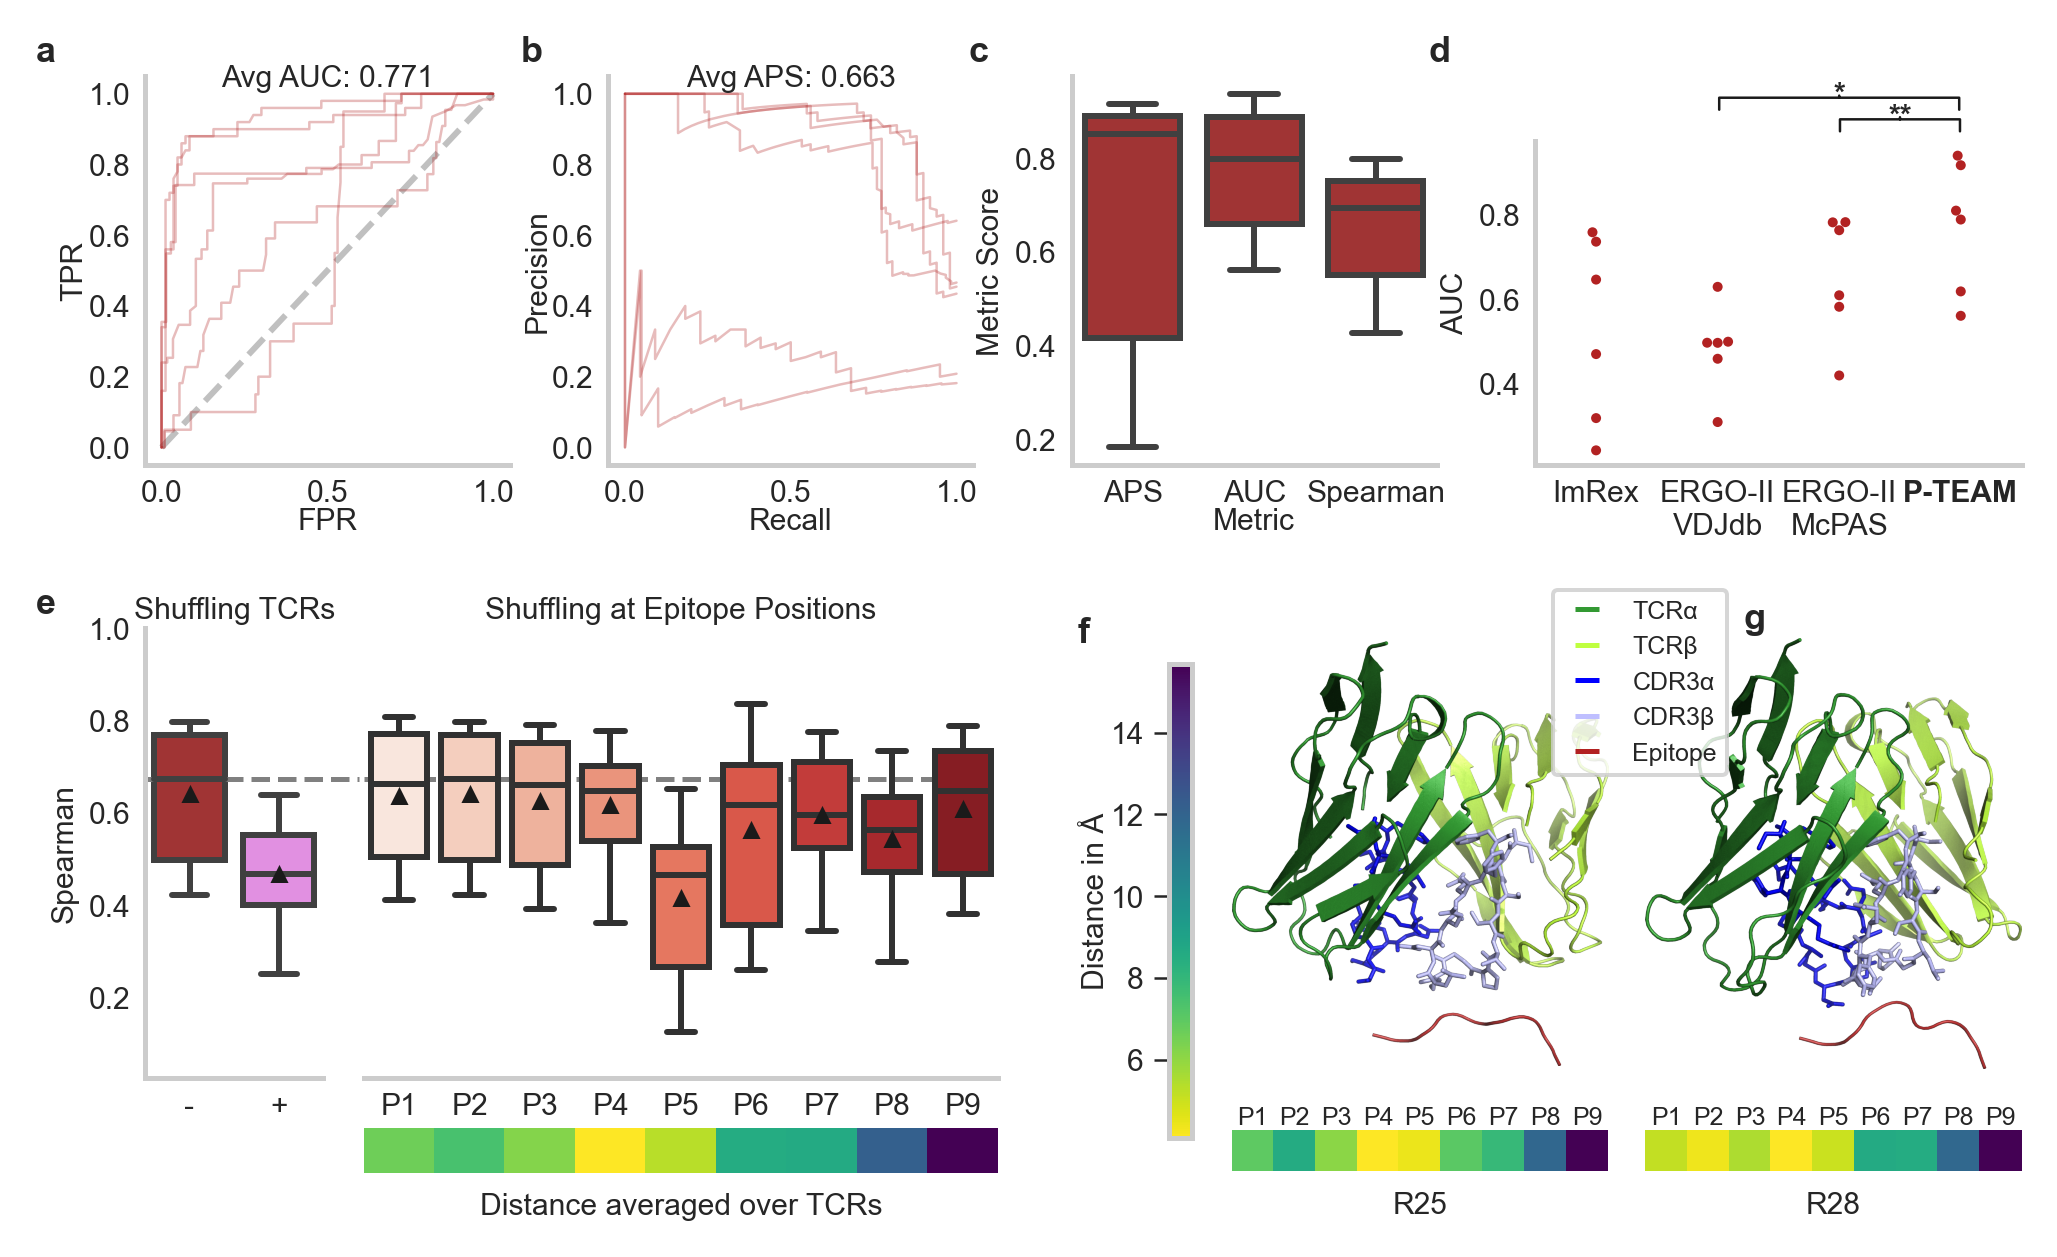

In [30]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.6), dpi=DPI)


gridspecs = {}
axes = {}

gridspecs['gs_full'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[0.25, 0.35],
    hspace=0.35,
)

gridspecs['gs_1-4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_full'][0],
    nrows=1,
    ncols=4,
    width_ratios=[0.75, 0.75, 0.75, 1],
    wspace=0.25,
)

gridspecs['gs_4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-4'][3],
    nrows=2,
    ncols=1,
    height_ratios=[0.2, 1],
    hspace=0
)

axes[f'ax_a'] = fig.add_subplot(gridspecs['gs_1-4'][0])
axes[f'ax_b'] = fig.add_subplot(gridspecs['gs_1-4'][1])
axes[f'ax_c'] = fig.add_subplot(gridspecs['gs_1-4'][2])

axes[f'ax_d_sign'] = fig.add_subplot(gridspecs['gs_4'][0])
axes[f'ax_d'] = fig.add_subplot(gridspecs['gs_4'][1])

plot_auc(pdf_classification[pdf_classification['Repertoire']=='Human'], axes['ax_a'], ylabel='TPR', xlabel='FPR')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Human'], axes['ax_b'], ylabel='Precision', xlabel='Recall',
         metric_func=metrics.precision_recall_curve,
         metric_name='APS')
plot_metric_boxplot(['APS', 'AUC', 'Spearman'], axes['ax_c'])
plot_baseline_data(performance_baseline, axes['ax_d'])
plot_significance(axes['ax_d_sign'])

# Structural modelling
tcr_mice = ('R25', 'R28')
vmin = min([d.min() for d in dists_human.values()])
vmax = max([d.max() for d in dists_human.values()])

gridspecs['gs5-13'] = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gridspecs['gs_full'][1],
        nrows=1,
        ncols=2,
        width_ratios=[1, 1],
        wspace=0.2
)

gridspecs['gs5-8'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs5-13'][1],
    nrows=1,
    ncols=2,
    width_ratios=[0.20, 1],
    wspace=-0.2,
    #hspace=-0.15
)  

gridspecs['gs6-8'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs5-8'][1],
    nrows=2,
    ncols=2,
    height_ratios=[10, 1],
    width_ratios=[1, 1],
    wspace=0.10
    #hspace=-0.15
)    
gridspecs['gs9-13'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs5-13'][0],
    nrows=2,
    ncols=2,
    height_ratios=[10, 1],
    width_ratios=[2.25, 8],
    wspace=0.1
)

axes['ax_5'] = fig.add_subplot(gridspecs['gs5-8'][0])
axes['ax_6'] = fig.add_subplot(gridspecs['gs6-8'][0])
axes['ax_7'] = fig.add_subplot(gridspecs['gs6-8'][1])
axes['ax_8'] = fig.add_subplot(gridspecs['gs6-8'][2])
axes['ax_9'] = fig.add_subplot(gridspecs['gs6-8'][3])
axes['ax_10'] = fig.add_subplot(gridspecs['gs9-13'][0])
axes['ax_11'] = fig.add_subplot(gridspecs['gs9-13'][1])
axes['ax_12'] = fig.add_subplot(gridspecs['gs9-13'][2])
axes['ax_13'] = fig.add_subplot(gridspecs['gs9-13'][3])


palette_base = [palette_tcrs['Human'], color_cdr3]

plot_colorbar(axes['ax_5'], epitope='VPSVWRSSL', do_legend=False, do_left=True)
plot_3d_structures(axes['ax_7'], tcr_mice[1])
plot_3d_distances(axes['ax_8'], tcr_mice[0])
plot_3d_distances(axes['ax_9'], tcr_mice[1])
plot_3d_structures(axes['ax_6'], tcr_mice[0], do_legend=True)
axes['ax_6'].set_zorder(1)

plot_3d_distances(axes['ax_13'], 'avg', do_labels=False)
plot_permutation_importance_base(df_importance_human, axes['ax_10'], palette_base, do_heading=True)
plot_permutation_importance_position(df_importance_human, axes['ax_11'], palette=palette_human, do_heading=True)
axes['ax_12'].axis('off')

fig.text(0.08, 0.89, 'a', size='large', weight='bold')
fig.text(0.28, 0.89, 'b', size='large', weight='bold')
fig.text(0.465, 0.89, 'c', size='large', weight='bold')
fig.text(0.655, 0.89, 'd', size='large', weight='bold')

fig.text(0.08, 0.51, 'e', size='large', weight='bold')
fig.text(0.51, 0.49, 'f', size='large', weight='bold')
fig.text(0.785, 0.50, 'g', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_fig6_generalizationHuman.pdf', dpi=DPI, bbox_inches='tight')

## Figure S6

<ipython-input-31-a36ccd8237d5>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


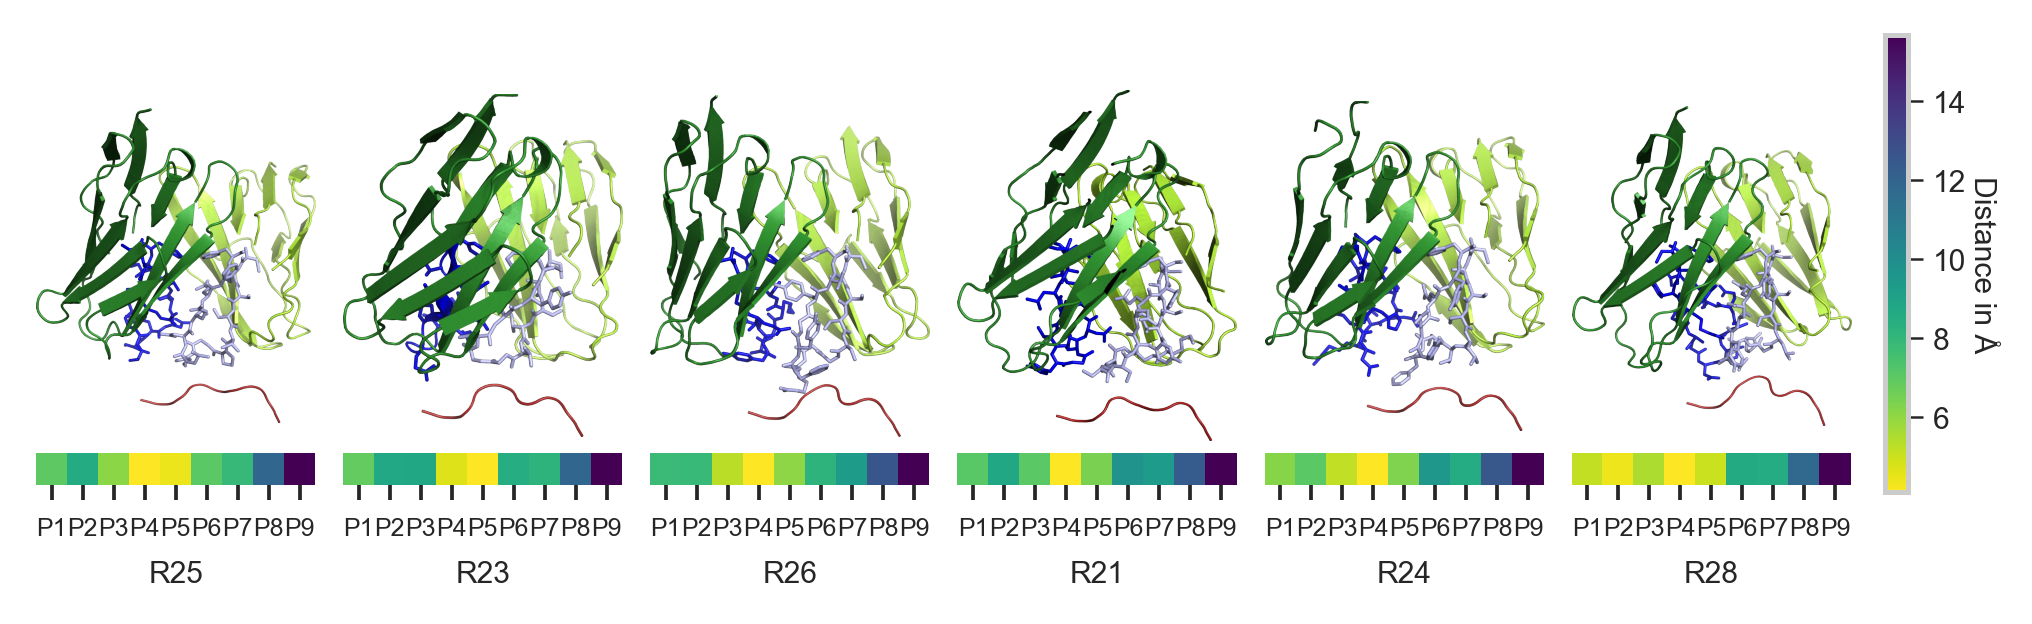

In [31]:
# Sorted by Reactivity to VPSVWRSSL
vis_names_human = ['R25', 'R23', 'R26', 'R21', 'R24', 'R28']

n_cols = 6
n_rows = (len(vis_names_human)-1)//6 + 1

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.25 * n_rows), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[10, 1],
    wspace=-0.12,
)

gs_vis = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=n_rows,
    ncols=n_cols,
    height_ratios=[1]*n_rows,
    width_ratios=[1] * n_cols,
    wspace=0.1,
    hspace=0.1
)

ax_cb = fig.add_subplot(gs[1])
plot_colorbar(ax_cb, 'VPR')

for i, tcr in enumerate(vis_names_human):
    row = i//n_cols
    col = i%n_cols
    gs_tcr = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs_vis[i],
        nrows=2,
        ncols=1,
        height_ratios=[1, 0.1],
        hspace=-0.2
    )
    ax_struc = fig.add_subplot(gs_tcr[0])
    plot_3d_structures(ax_struc, tcr)
    
    ax_dists = fig.add_subplot(gs_tcr[1])
    plot_3d_distances(ax_dists, tcr, legend_top=False)
    
    #fig.text(0.125 + 0.127*col, 0.78-row*0.13, abc[i], size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_3dModelHuman.pdf', dpi=DPI, bbox_inches='tight')

## Statistics for the paper

In [32]:
print('\nauc summary mice\n',
    df_classification_metrics.groupby('Repertoire').describe().T
)

metrics_class_human = df_classification_metrics[df_classification_metrics['Repertoire']=='Human']

print('\nbest human\n', metrics_class_human.sort_values('AUC').tail(3))
print('\nworst human\n', metrics_class_human.sort_values('AUC').head(3))

print('\nbelow random\n', df_classification_metrics.query('AUC < 0.5').sort_values('AUC'))



auc summary mice
 Repertoire      Human
index count  6.000000
      mean   2.500000
      std    1.870829
      min    0.000000
      25%    1.250000
      50%    2.500000
      75%    3.750000
      max    5.000000
AUC   count  6.000000
      mean   0.771469
      std    0.153750
      min    0.560619
      25%    0.660502
      50%    0.798098
      75%    0.888899
      max    0.938193
APS   count  6.000000
      mean   0.663258
      std    0.338638
      min    0.182630
      25%    0.417137
      50%    0.853195
      75%    0.890158
      max    0.916262

best human
    index  tcr       AUC       APS Repertoire
3      3  R25  0.808610  0.863954      Human
4      4  R26  0.915663  0.898892      Human
0      0  R21  0.938193  0.916262      Human

worst human
    index  tcr       AUC       APS Repertoire
5      5  R28  0.560619  0.182630      Human
2      2  R24  0.618141  0.275371      Human
1      1  R23  0.787586  0.842437      Human

below random
 Empty DataFrame
Columns: [ind

In [33]:
print('Paired t-test between P-TEAM and baseline models on AUC:')
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline[col], performance_baseline['P-TEAM'])
    print(f'{col}: {res}')
    
print('\nPaired t-test between P-TEAM and baseline models on Spearman:')
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline_regression[col], performance_baseline_regression['P-TEAM'])
    print(f'{col}: {res}')

Paired t-test between P-TEAM and baseline models on AUC:
ergo-mcpas: Ttest_relResult(statistic=-4.747349635063671, pvalue=0.005116550148906997)
ergo-vdjdb: Ttest_relResult(statistic=-3.7041834693882825, pvalue=0.013938746730642273)
imrex: Ttest_relResult(statistic=-1.8294804600424919, pvalue=0.12685241879987116)

Paired t-test between P-TEAM and baseline models on Spearman:
ergo-mcpas: Ttest_relResult(statistic=-5.392598299800419, pvalue=0.0029599510861935212)
ergo-vdjdb: Ttest_relResult(statistic=-8.547286692488154, pvalue=0.00036098535107801543)
imrex: Ttest_relResult(statistic=-2.9283712101373274, pvalue=0.03269447161813724)


In [34]:
print('Mean performance of the baseline models (AUC):')
print(performance_baseline.mean())

Mean performance of the baseline models (AUC):
ergo-mcpas    0.655928
ergo-vdjdb    0.481992
imrex         0.528689
P-TEAM        0.771469
dtype: float64


In [35]:
df_classification_metrics[['tcr', 'AUC', 'APS']].sort_values('tcr').round(3)

,tcr,AUC,APS
0,R21,0.938,0.916
1,R23,0.788,0.842
2,R24,0.618,0.275
3,R25,0.809,0.864
4,R26,0.916,0.899
5,R28,0.561,0.183


In [36]:
df_regression_metrics[['tcr', 'Spearman']].sort_values('tcr').round(3).sort_values('Spearman')

,tcr,Spearman
2,R24,0.427
5,R28,0.509
3,R25,0.681
1,R23,0.708
4,R26,0.766
0,R21,0.800


# Supplement Structures

<ipython-input-37-bc451b338e1a>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


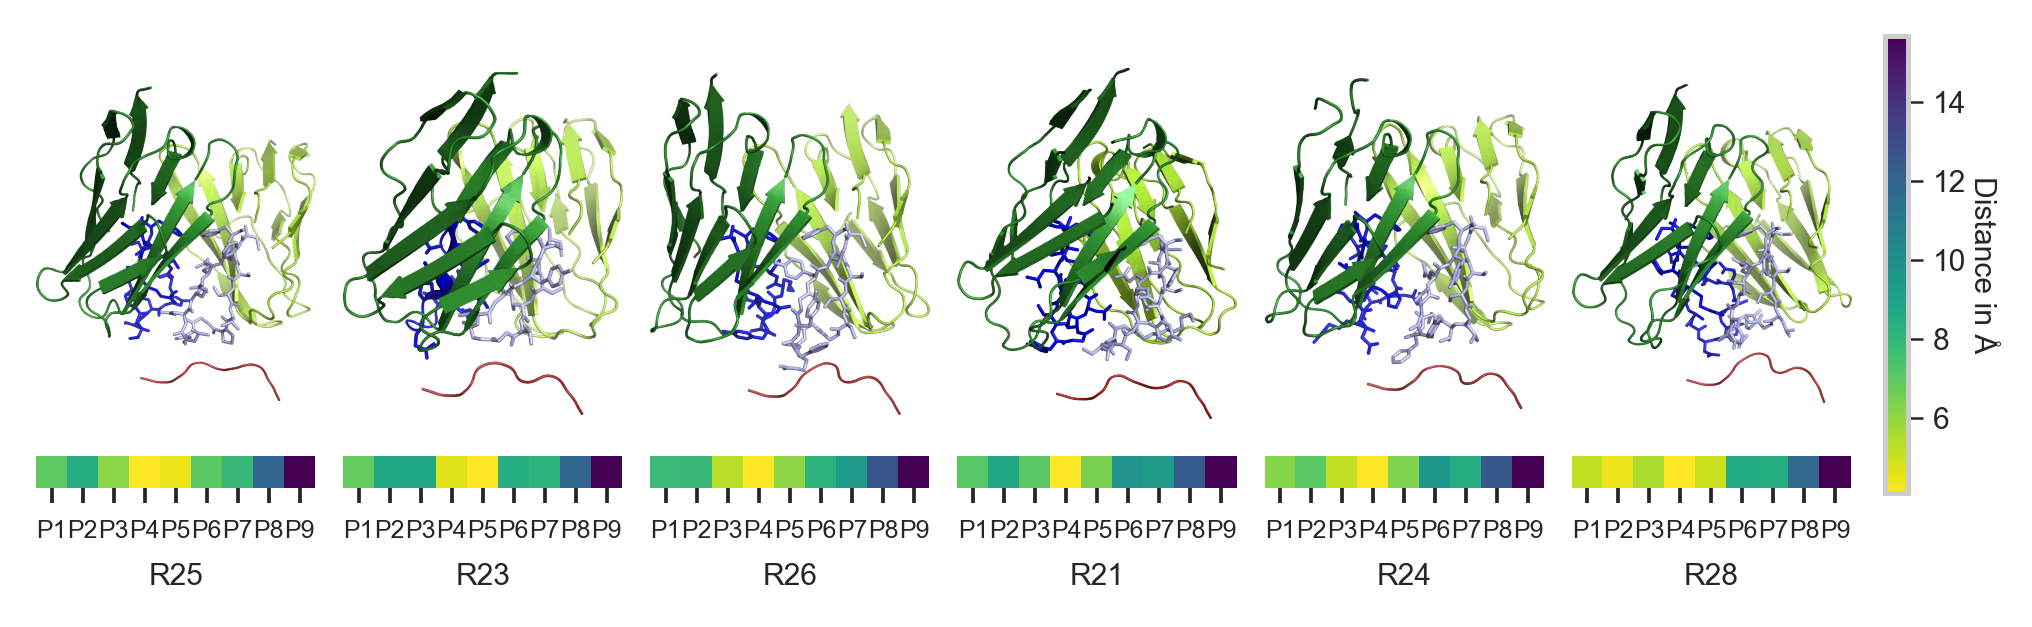

In [37]:
n_cols = 6
n_rows = (len(vis_names_human)-1)//6 + 1

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.25 * n_rows), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[10, 1],
    wspace=-0.12,
)

gs_vis = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=n_rows,
    ncols=n_cols,
    height_ratios=[1]*n_rows,
    width_ratios=[1] * n_cols,
    wspace=0.1,
    hspace=0.3 # 0.2
)

ax_cb = fig.add_subplot(gs[1])
plot_colorbar(ax_cb, 'VPSVWRSSL')

# Sorted by reactivity to VPS
vis_names_human = ['R25', 'R23', 'R26', 'R21', 'R24', 'R28']

for i, tcr in enumerate(vis_names_human):
    row = i//n_cols
    col = i%n_cols
    gs_tcr = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs_vis[i],
        nrows=2,
        ncols=1,
        height_ratios=[1, 0.1],
        hspace=-0.
    )
    ax_struc = fig.add_subplot(gs_tcr[0])
    plot_3d_structures(ax_struc, tcr)
    
    ax_dists = fig.add_subplot(gs_tcr[1])
    plot_3d_distances(ax_dists, tcr, legend_top=False)
    
    #fig.text(0.125 + 0.127*col, 0.87-row*0.129, abc[i], size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_3dModelHuman.pdf', dpi=DPI, bbox_inches='tight')

# Stats for paper

In [38]:
dists_human_avg = np.vstack([dist for tcr, dist in dists_human.items()]).mean(axis=0)
dists_human_avg = pd.DataFrame(data=dists_human_avg, index=[f'P{i+1}' for i in range(9)], columns=['distance'])

df_importance_human_avg = df_importance_human.groupby(['Permutation']).mean().sort_values('Spearman')
df_importance_human_avg = pd.concat([df_importance_human_avg, dists_human_avg], axis=1)
df_importance_human_avg

,Spearman,base,diff,rel,distance
P5,0.412786,0.639038,-0.226252,-0.374530,5.641836
CDR3,0.464492,0.639038,-0.174546,-0.261925,NaN
P8,0.541923,0.639038,-0.097115,-0.148192,11.670817
P6,0.560551,0.639038,-0.078488,-0.139928,8.498233
P7,0.592822,0.639038,-0.046216,-0.066696,8.557034
P9,0.606159,0.639038,-0.032879,-0.054359,14.799690
P4,0.614163,0.639038,-0.024875,-0.025358,4.528241
P3,0.624202,0.639038,-0.014836,-0.023615,6.418907
P1,0.635405,0.639038,-0.003633,-0.004036,6.777392
-,0.639038,0.639038,0.000000,0.000000,NaN


In [39]:
print('Human: correlation and p-value between Spearman and distance')
df_human_pos = df_importance_human_avg[df_importance_human_avg.index.str.startswith('P') 
                                       & (df_importance_human_avg.index != 'P2')]
stats.pearsonr(df_human_pos['Spearman'], df_human_pos['distance'])

Human: correlation and p-value between Spearman and distance


(0.11204685975426512, 0.7916638805478258)

In [40]:
dists_human_df = np.vstack([dist for tcr, dist in dists_human.items()]).transpose()
dists_human_df = pd.DataFrame(data=dists_human_df, 
                               index=[f'P{i+1}' for i in range(9)], 
                               columns=dists_human.keys())
dists_human_df

,R21,R23,R24,R25,R26,R28
P1,7.038514,6.463537,6.389133,6.887116,7.864715,6.021338
P2,8.664587,8.022562,7.126117,8.195330,7.889381,5.309001
P3,6.984971,8.070881,5.561386,6.184569,5.364574,6.347065
P4,4.098284,4.631594,4.615252,4.579704,4.186455,5.058159
P5,6.362323,4.103581,6.509049,4.853171,6.114430,5.908464
P6,9.560147,7.834366,9.203836,6.965160,8.202807,9.223079
P7,9.240887,7.588848,8.363011,7.645446,9.348893,9.155120
P8,12.133603,10.703330,11.699807,10.790216,12.546938,12.151008
P9,15.374036,13.915141,14.364870,13.873730,15.586619,15.683747
